## Лабораторная работа №6
### Выполнила Прудникова А. А.  М8О-408Б-20
#### Вариант 4

 Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import sys
import ipywidgets as widgets
import warnings

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
from IPython.display import display



$$\displaystyle\frac{\partial^2 u}{\partial t^2} =  \displaystyle\frac{\partial^2 u}{\partial x^2} -5 u $$


\begin{equation*}
 \begin{cases}
   u_{x} (0, \: t) = 2u(0, t)
   \\
   u_{x} (1, \: t) =  2u(1, t)
   \\
   u(x, \: 0) =  e^{2x}
   \\
   u_{t}(x, 0) =  0
 \end{cases}
\end{equation*}

$$u(x, t) = e^{2x} \cos{t}$$

In [2]:
def psi_1(x):
    return math.exp(2*x)

def psi_2(x):
    return 0

def dpsi2_dx2(x):
    return 4*psi_1(x)

# analytic solve
def u(x, t):
    return math.exp(2*x)*math.cos(t)

## <center> Конечно-разностная схема </center>

In [4]:

class Schema:
    def __init__(self, psi1 = psi_1, psi2 = psi_2, diffpsi2 = dpsi2_dx2,
                 l0 = 0, l1 = 1, T = 5, order2nd = True, aprx_cls = None):
        self.psi1 = psi1
        self.diffpsi = diffpsi2
        self.psi2 = psi2
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.approx = None
        self.order = order2nd
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        
    def _init_approx(self, a_cls):
        self.approx = a_cls()
    
    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)
        
    def set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def set_T(self, T):
        self.T = T
        
    def _compute_h(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def _compute_tau(self, K):
        self.tau = self.T / K
        
    def _compute_sigma(self):
        self.sigma = self.tau*self.tau / (self.h*self.h)
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
        
    def _compute_line(self, t, x, last_line1, last_line2):
        pass
    
    def __call__(self, N=30, K=200):
        N, K = N-1, K-1
        self._compute_tau(K)
        self._compute_h(N)
        self._compute_sigma()
        ans = []
        x = list(self.nparange(self.l0, self.l1, self.h))
        
        last_line = list(map(self.psi1, x))
        
        ans.append(list(last_line))
    
        if self.order:
            last_line = list(map(
                lambda a: self.psi1(a) + self.tau*self.psi2(a) + self.tau*self.tau*self.diffpsi(a)/2, 
                x
            ))
        else:
            last_line = list(map(lambda a: self.psi1(a) + self.tau*self.psi2(a), x))

        ans.append(list(last_line))
        

        X = [x, x]
        Y = [[0.0 for _ in x]]
        Y.append([self.tau for _ in x])
 
        for t in self.nparange(self.tau + self.tau, self.T, self.tau):
  
            ans.append(self._compute_line(t, x, ans[-1], ans[-2]))
            X.append(x)
            Y.append([t for _ in x])
        return X, Y, ans

<h3><center> Явная конечно-разностная схема </center></h3>

In [5]:
class Explict_Schema(Schema):
    def _compute_sigma(self):
        self.sigma =  self.tau*self.tau / (self.h * self.h)
        if self.sigma > 1:
            warnings.warn("Sigma > 1")
        
    def _compute_line(self, t, x, last_line1, last_line2):
        line = [None for _ in last_line1]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma*(last_line1[i-1] - 2*last_line1[i] + last_line1[i+1])
            line[i] -= 5*self.tau*self.tau*last_line1[i]
            line[i] += 2*last_line1[i]
            line[i] -= last_line2[i]
        line[0] = self.approx.explict_0(self.h, self.sigma, line, last_line1, last_line2, self.tau)
        line[-1] = self.approx.explict_l(self.h, self.sigma, line, last_line1, last_line2, self.tau)
        return line

<h3><center>Неявная конечно-разностная схема</center></h3>

In [6]:
class Implict_Schema(Schema):
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x
    
    def _compute_line(self, t, x, last_line1, last_line2):
        a = 1
        b = -(2 + 5*self.h*self.h + 1/self.sigma)
        
        A = [(a, b, a) for _ in range(1, len(x)-1)]
        w = [
            (last_line2[i] - 2*last_line1[i]) / self.sigma
            for i in range(1, len(x)-1)
        ]
        
        koeffs = self.approx.implict_0(self.h, self.sigma, last_line1, last_line2)
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        
        koeffs = self.approx.implict_l(self.h, self.sigma, last_line1, last_line2)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        return self.race_method(A, w)

<h2><center> Апроксимация первых производных </center></h2>

In [7]:
class Approx:
    def __init__(self):
        pass
        
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        pass
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        pass
    
    def implict_0(self, h, sigma, l0, l1):
        pass
    def implict_l(self, h, sigma, l0, l1):
        pass

<h3><center> Двухточечная первого порядка </h2></center>

In [8]:
class approx_two_one(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        return line[1] / (1 + 2*h)
    
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        return line[-2] / (1 - 2*h)
    
    def implict_0(self, h, sigma, l0, l1):
        return 0, (1 + 2*h), -1, 0
    
    def implict_l(self, h, sigma, l0, l1):
        return -1, (1 - 2*h), 0, 0

<h3><center>Трёхточечная второго порядка</center></h3>

In [9]:
class approx_three_two(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        return (4*line[1] - line[2]) / (3 + 4*h)
                
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        return (4*line[-2] - line[-3]) / (3 - 4*h)
    
    def implict_0(self, h, sigma, l0, l1):
        return 0, -(2 + 4*h), -(5*h*h + 1/sigma - 2), (-2*l0[1] + l1[1])/sigma
    
    def implict_l(self, h, sigma, l0, l1):
        return -(5*h*h + 1/sigma - 2), -(2 - 4*h), 0, (-2*l0[-2] + l1[-2])/sigma

<h3><center> Двухточечная второго порядка </center></h3>

In [10]:
class approx_two_two(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        ans = sigma*(2*last_line1[1] - (2 + 4*h)*last_line1[0]) 
        ans += (2 - 5*tau*tau)*last_line1[0] - last_line2[0]
        return ans
                
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        ans = sigma*(2*last_line1[-2] + (4*h - 2)*last_line1[-1]) 
        ans += (2 - 5*tau*tau)*last_line1[-1] - last_line2[-1]
        return ans
    
    def implict_0(self, h, sigma, l0, l1):
        return 0, -(2 + 5*h*h + 4*h + 1/sigma), 2, (-2*l0[0] + l1[0])/sigma
    
    def implict_l(self, h, sigma, l0, l1):
        return 2, -(2 + 5*h*h - 4*h + 1/sigma), 0, (-2*l0[-1] + l1[-1])/sigma

<h3><center> Зависимость погрешности от параметра $h$ </center></h3>

#### Вычисление погрешностей

Вычисление погрешности: $e = \| \hat{z} - z \|_2$, где $\hat{z}$,  $z$ - матрицы  вычесленных и реальных значений функции в сетке.

In [11]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            temp = abs(z[i][j] - f(x[i][j], y[i][j]))
            ans = temp if temp > ans else ans
    return ans

In [12]:
def get_graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(4, 50, 1):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
    return h, e

In [13]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

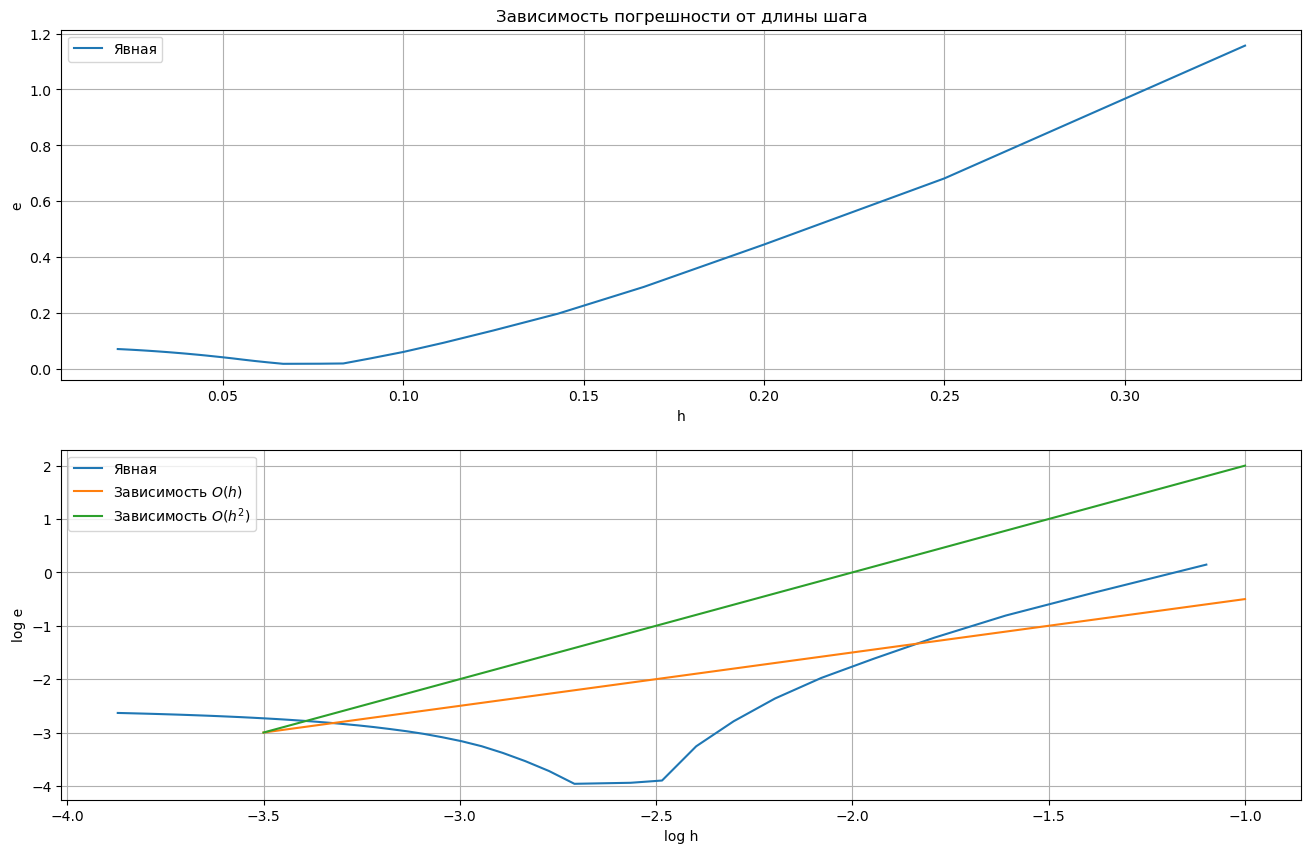

In [14]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explict, u)

plt.plot(h, e, label="Явная")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Явная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.legend()
plt.grid()

#### Неявная схема

In [15]:
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two)

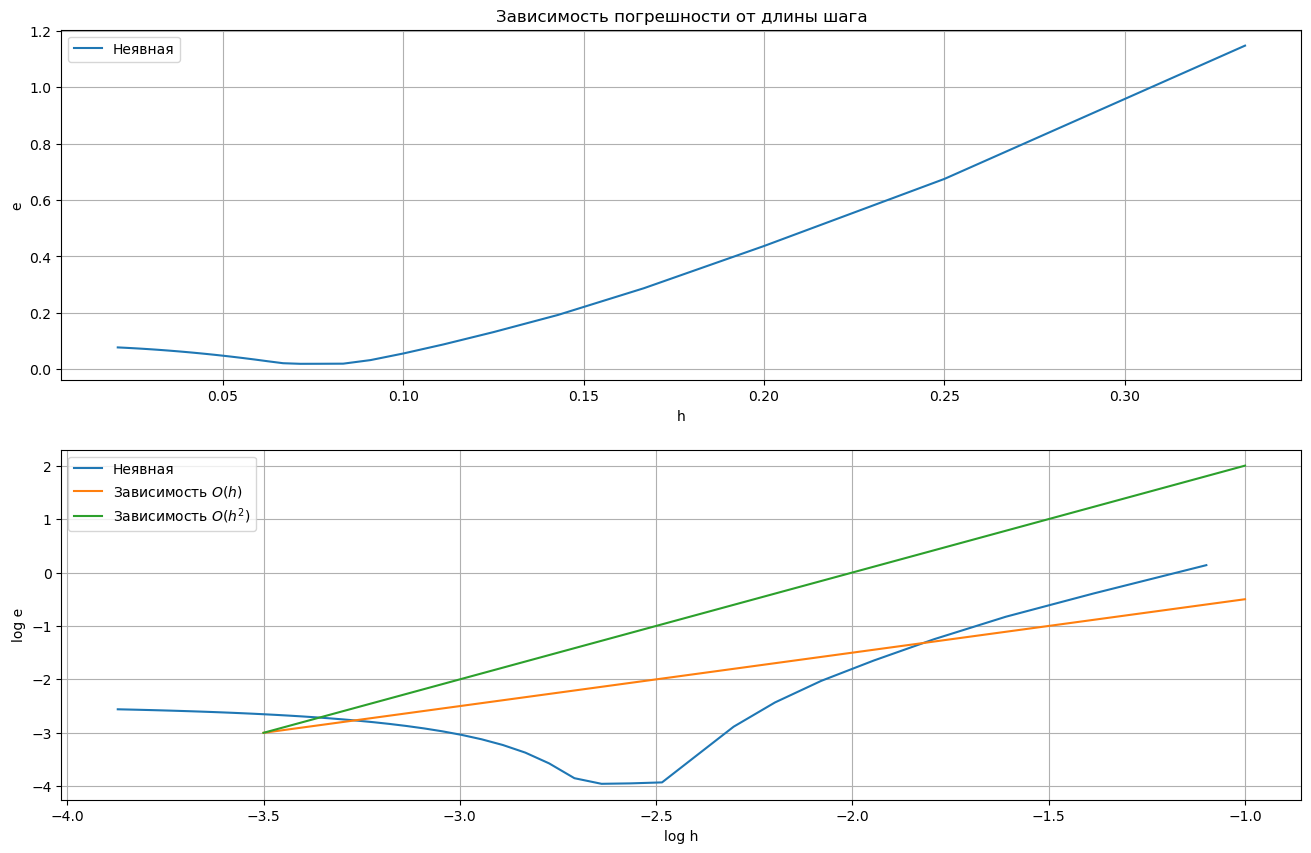

In [16]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(implict, u)

plt.plot(h, e, label="Неявная")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Неявная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.legend()
plt.grid()

<h3><center> Зависимость погрешности от параметра $\tau$ </center></h3>

#### Вычисление погрешности

In [17]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K = K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

In [18]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

C:\Users\nprud\AppData\Local\Temp\ipykernel_35228\3357846069.py:5: UserWarning: Sigma > 1
  warnings.warn("Sigma > 1")


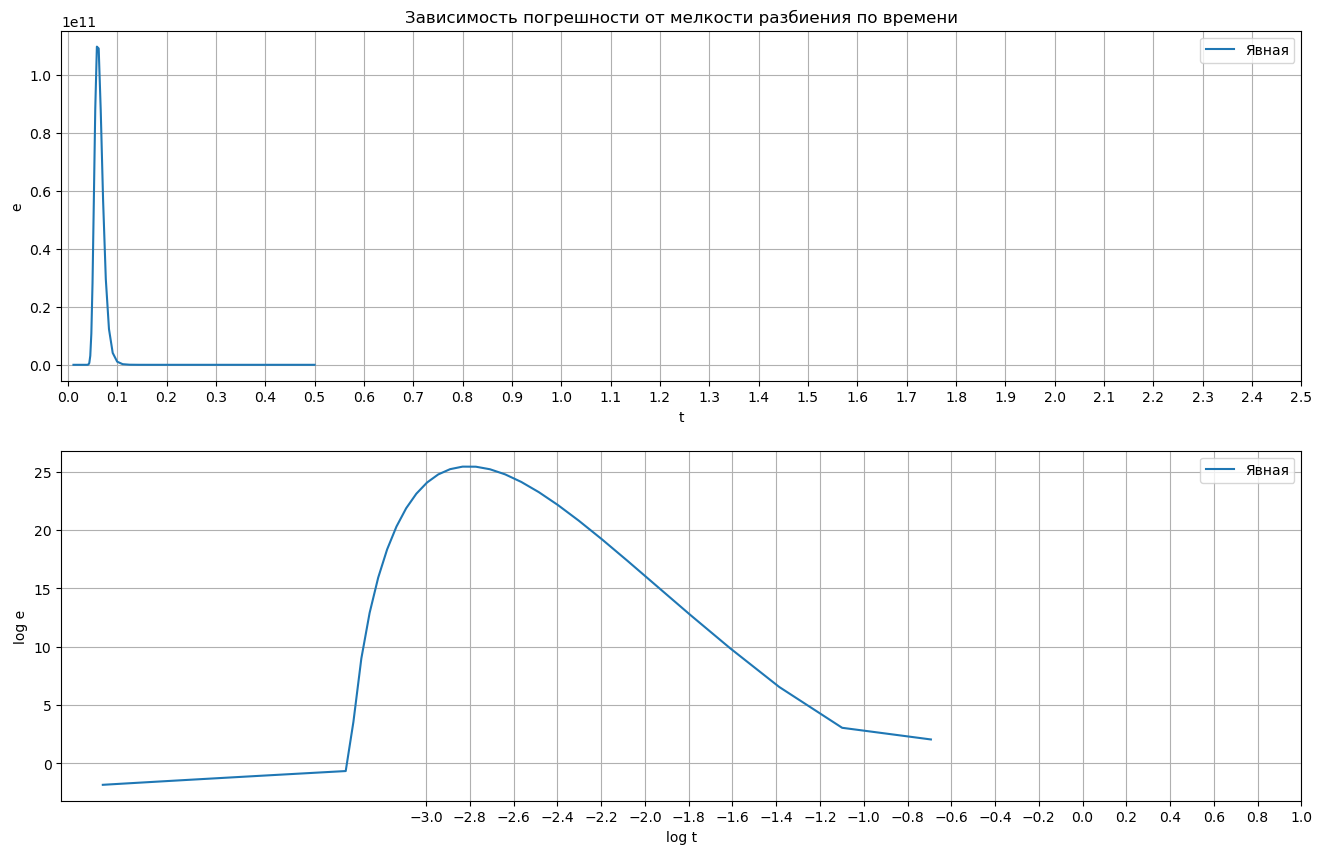

In [19]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explict, u)

plt.plot(tau, e, label="Явная")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Явная")
plt.xlabel("log t")
plt.ylabel("log e")
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [19]:
# Krank Nikolson with O = 1 is implict schema
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two, order2nd=True)

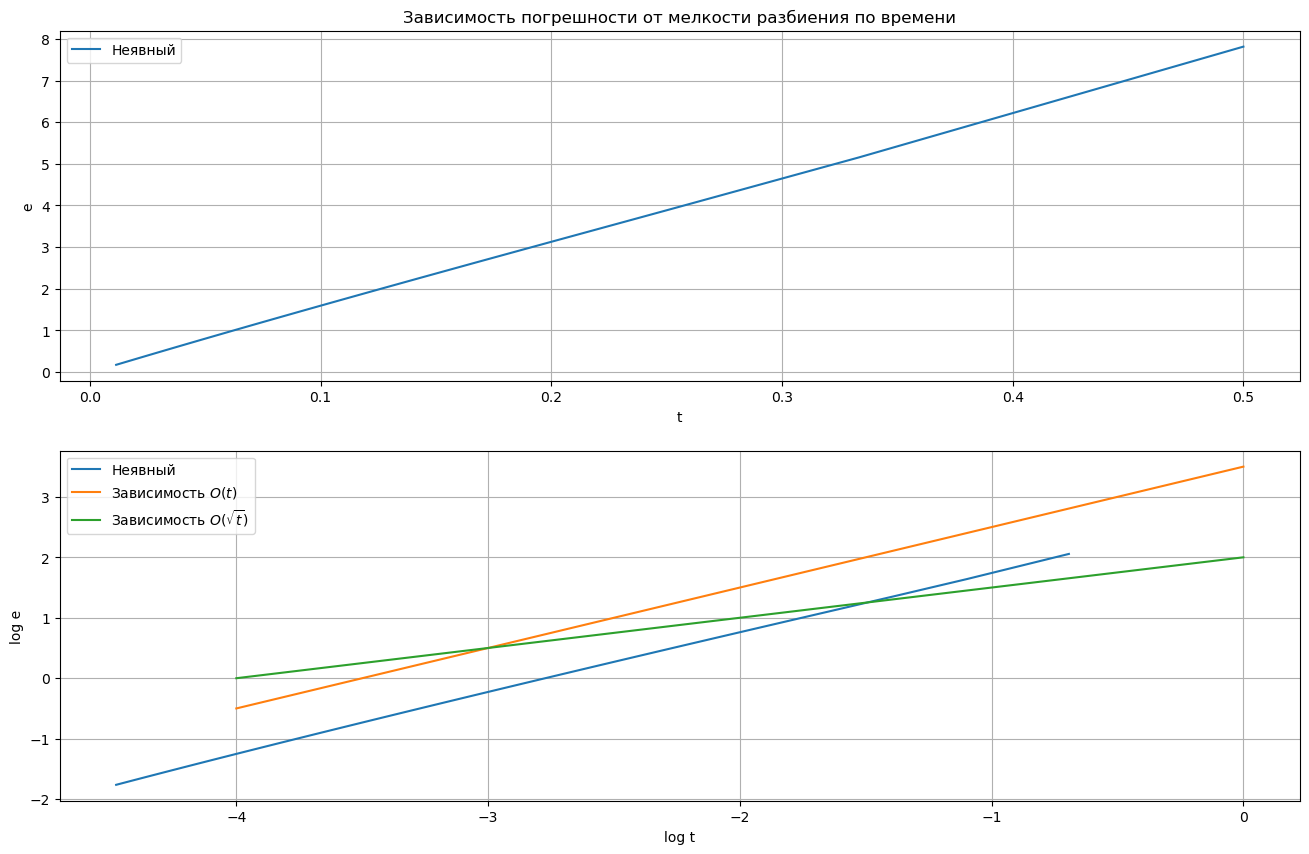

In [20]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(implict, u)

plt.plot(tau, e, label="Неявный")
plt.xlabel("t")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Неявный")
plt.plot([-4, 0], [-0.5, 3.5], label="Зависимость $O(t)$")
plt.plot([-4, 0], [0, 2], label="Зависимость $O(\sqrt{t})$")
plt.xlabel("log t")
plt.ylabel("log e")

plt.legend()
plt.grid()